Building likelihood maps for a set of representative images.

> TODO: use images from dataset and superimpose the bounding boxes on them


In [1]:
import retinoto_py as fovea
args = fovea.Params(do_fovea=True, batch_size=1, subset_factor=1)
# args = fovea.Params(do_mask=True, batch_size=1, subset_factor=1)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-7.5, padding_mode='zeros', seed=2025, batch_size=1, num_workers=1, in_memory=False, model_name='convnext_base', num_epochs=41, subset_factor=1, lr=2e-07, delta1=0.2, delta2=0.007, weight_decay=0.003, label_smoothing=0.05, do_full_training=False, shuffle=True, verbose=False)

In [2]:
dataset = 'bbox'
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, do_full_preprocess=False)
val_loader = fovea.get_loader(args, val_dataset)

Loading labels from local cache cached_data/imagenet_class_index.json...
Loading labels from local cache cached_data/imagenet_class_index.json...


In [3]:
model_filename = args.data_cache /  f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
# model_filename = args.data_cache /  f'20_model_name={args.model_name}_dataset={dataset}.pth'
model = fovea.load_model(args, model_filename=model_filename)
model_filename

PosixPath('cached_data/32_fovea_model_name=convnext_base_dataset=bbox.pth')

In [4]:
npy_filename = args.data_cache / '42_likelihood_maps_another-subset.npy'

%rm {npy_filename}

resolution = (100, 100)
resolution = (30, 30)
resolution = (25, 25)
resolution = (15, 15)
size_ratio = .5

n_batch = 100

if npy_filename.exists():
    results = fovea.np.load(npy_filename)
else:
    n_dataset = len(val_dataset)
    results = fovea.np.empty((resolution[0], resolution[1], n_batch))
    # for i_batch, (image, true_label) in fovea.tqdm(enumerate(val_dataset), total=n_batch):
    for i_batch, (image, true_label) in fovea.tqdm(enumerate(val_loader), total=n_batch):
        if i_batch >= n_batch : break
        image, true_label = image.to(args.device), true_label.to(args.device)

        pos_H, pos_W, probas = fovea.compute_likelihood_map(args, model, image.squeeze(0), size_ratio=size_ratio, resolution=resolution)
        # proba_result = probas[:, true_label]
        proba_result, idxs = probas.max(axis=-1)
        results[:, :, i_batch] = proba_result.cpu().numpy().reshape(resolution)
    fovea.np.save(npy_filename, results)

  0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
idxs, true_label

(tensor([214, 283, 283, 283, 283, 283, 794, 281, 794, 232, 568, 749, 439, 233, 233, 905, 283, 283, 283, 283, 283, 283, 281, 283, 187, 568,
         439, 281, 187, 187, 283, 283, 283, 283, 283, 283, 283, 283, 281, 568, 187, 187, 187, 187, 187, 283, 224, 283, 283, 283, 283, 283,
         283, 281, 283, 256, 187, 187, 187, 219, 283, 283, 283, 283, 283, 283, 283, 283, 244, 377, 297, 568, 380, 160, 283, 283, 283, 283,
         283, 283, 252, 283, 187, 439, 368, 377, 358, 377, 160, 380, 283, 283, 377, 283, 283, 283, 244, 361, 439, 364, 283, 283, 294, 283,
         283, 283, 283, 283, 283, 283, 283, 244, 230, 378, 252, 283, 233, 568, 283, 283, 192, 283, 380, 283, 380, 283, 283, 252, 283, 252,
         233, 283, 283, 283, 283, 334, 256, 377, 377, 377, 283, 283, 283, 283, 252, 252, 439, 439, 439, 223, 700, 182, 283, 283, 283, 283,
         283, 283, 283, 283, 283, 252, 283, 584, 584, 619, 753, 283, 283, 380, 265, 283, 283, 283, 252, 252, 252, 439, 584, 224, 905, 905,
         753, 359, 283, 283

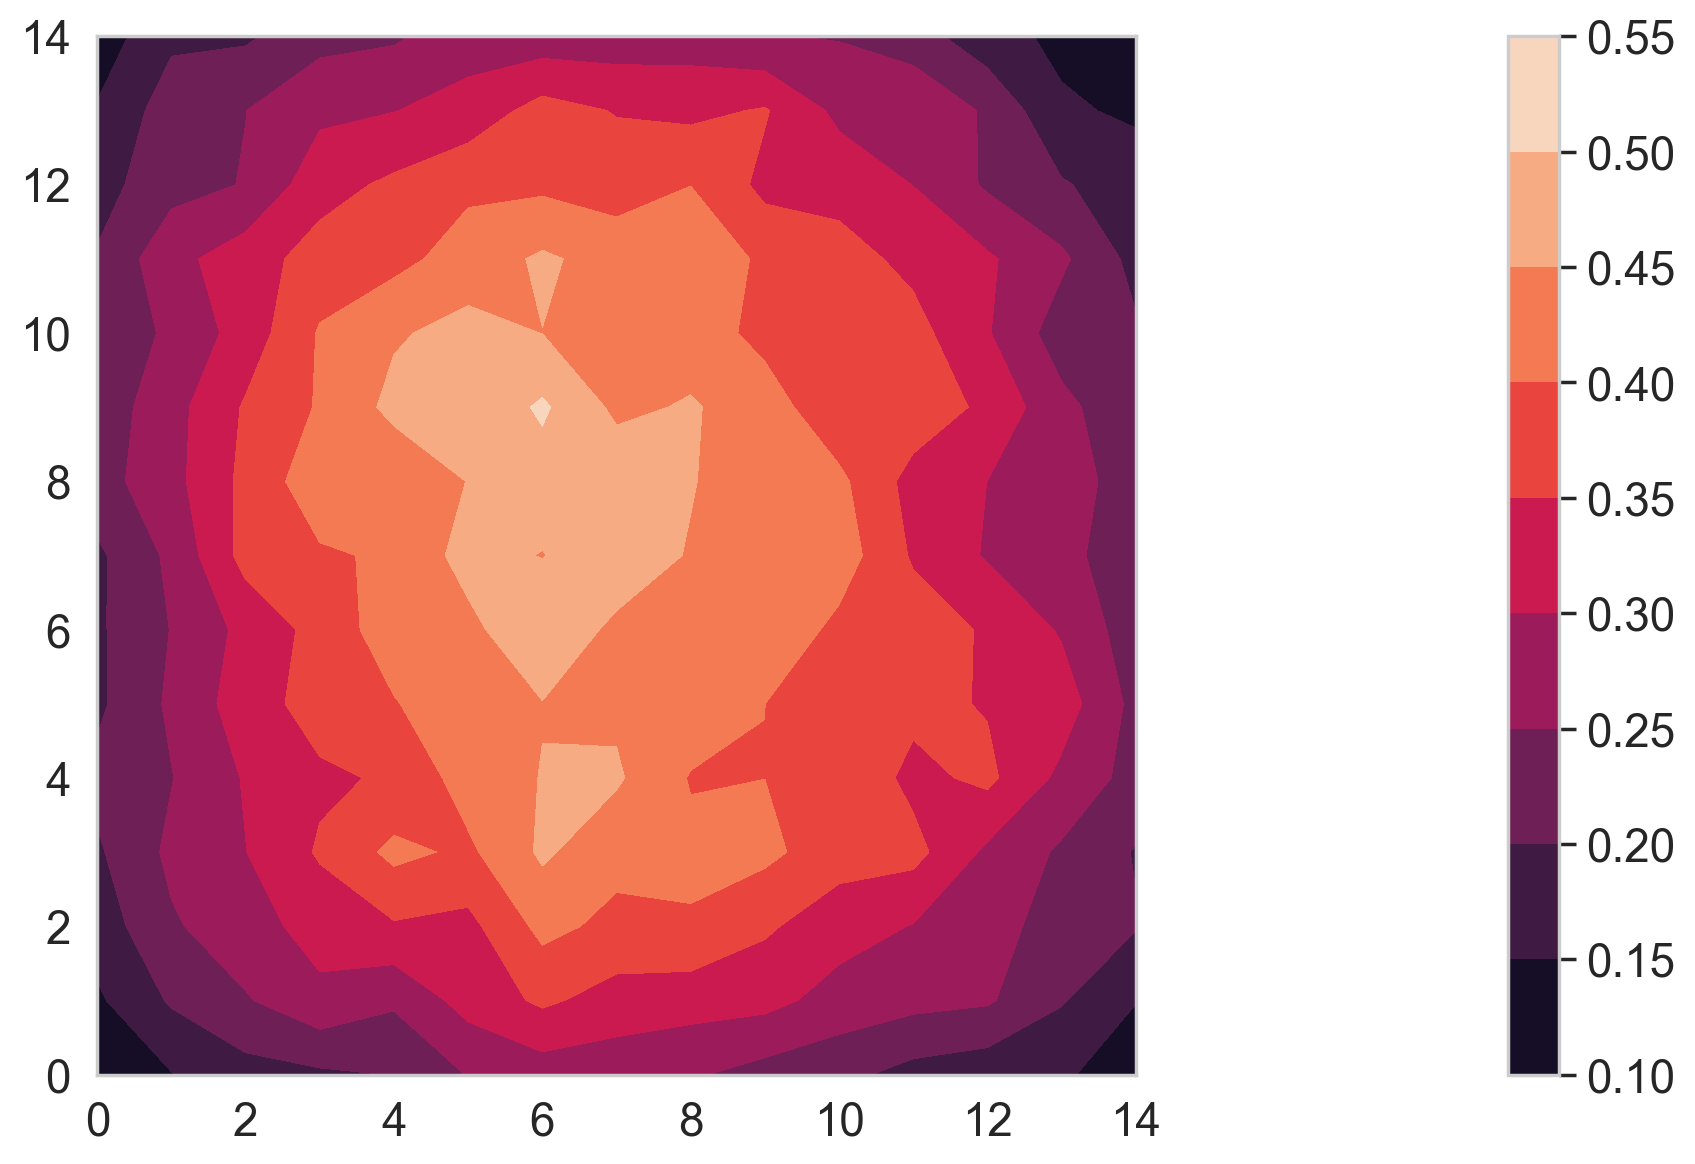

In [6]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(results.mean(axis=-1))
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')


In [7]:
results.min(), results.max()

(np.float64(0.0003818957775365561), np.float64(0.9897734522819519))

In [8]:
results.max(axis=-1).shape

(15, 15)

In [9]:
results.shape

(15, 15, 100)

In [10]:
i_image = 2
proba = results[:, :, i_image]
proba.min(), proba.max()

(np.float64(0.0024271702859550714), np.float64(0.776227593421936))

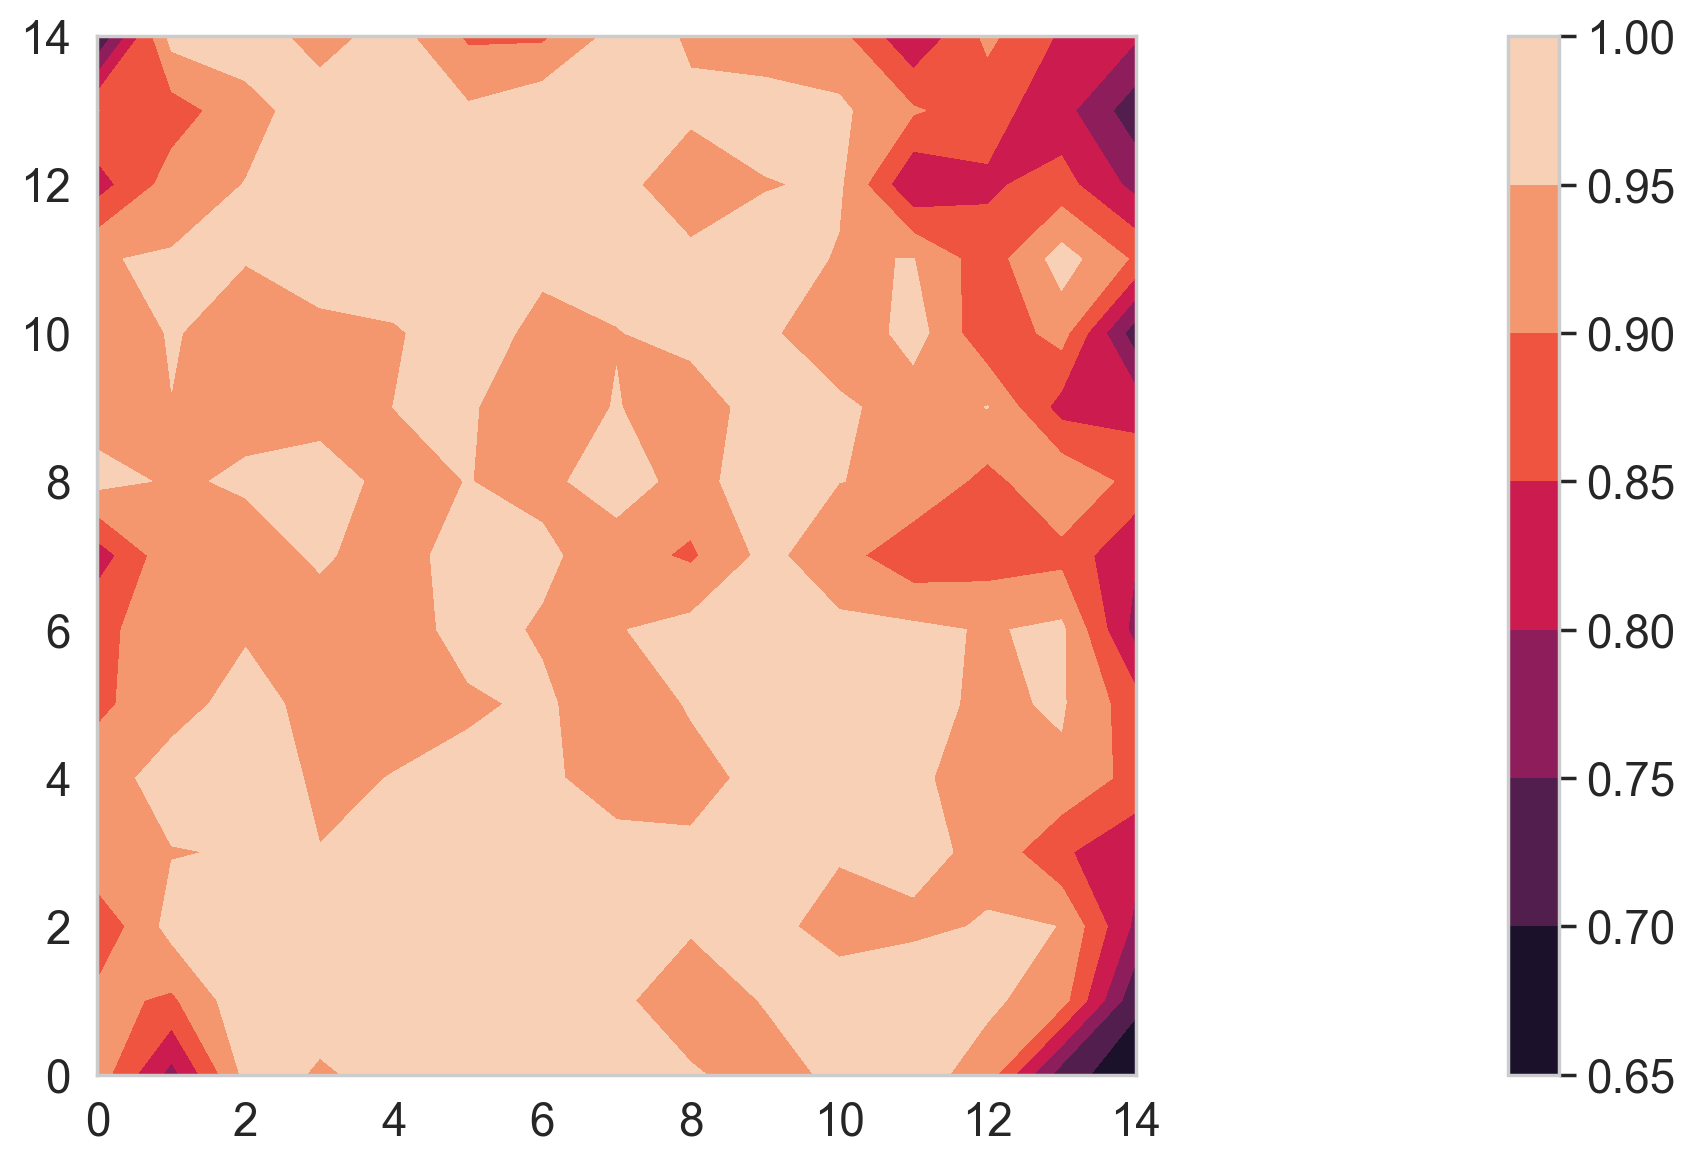

In [11]:
fig, ax = fovea.plt.subplots()
contour = ax.contourf(results.max(axis=-1), vmax=1)
fig.colorbar(contour, ax=ax)  # Add colorbar
ax.axis('square')
fig.set_facecolor(color='white')

In [12]:
results.max(axis=(0, 1)).shape

(100,)

(array([ 1.,  5.,  1.,  6.,  5.,  6., 14., 18., 18., 26.]),
 array([0.65954202, 0.69256517, 0.72558831, 0.75861145, 0.7916346 ,
        0.82465774, 0.85768088, 0.89070402, 0.92372717, 0.95675031,
        0.98977345]),
 <BarContainer object of 10 artists>)

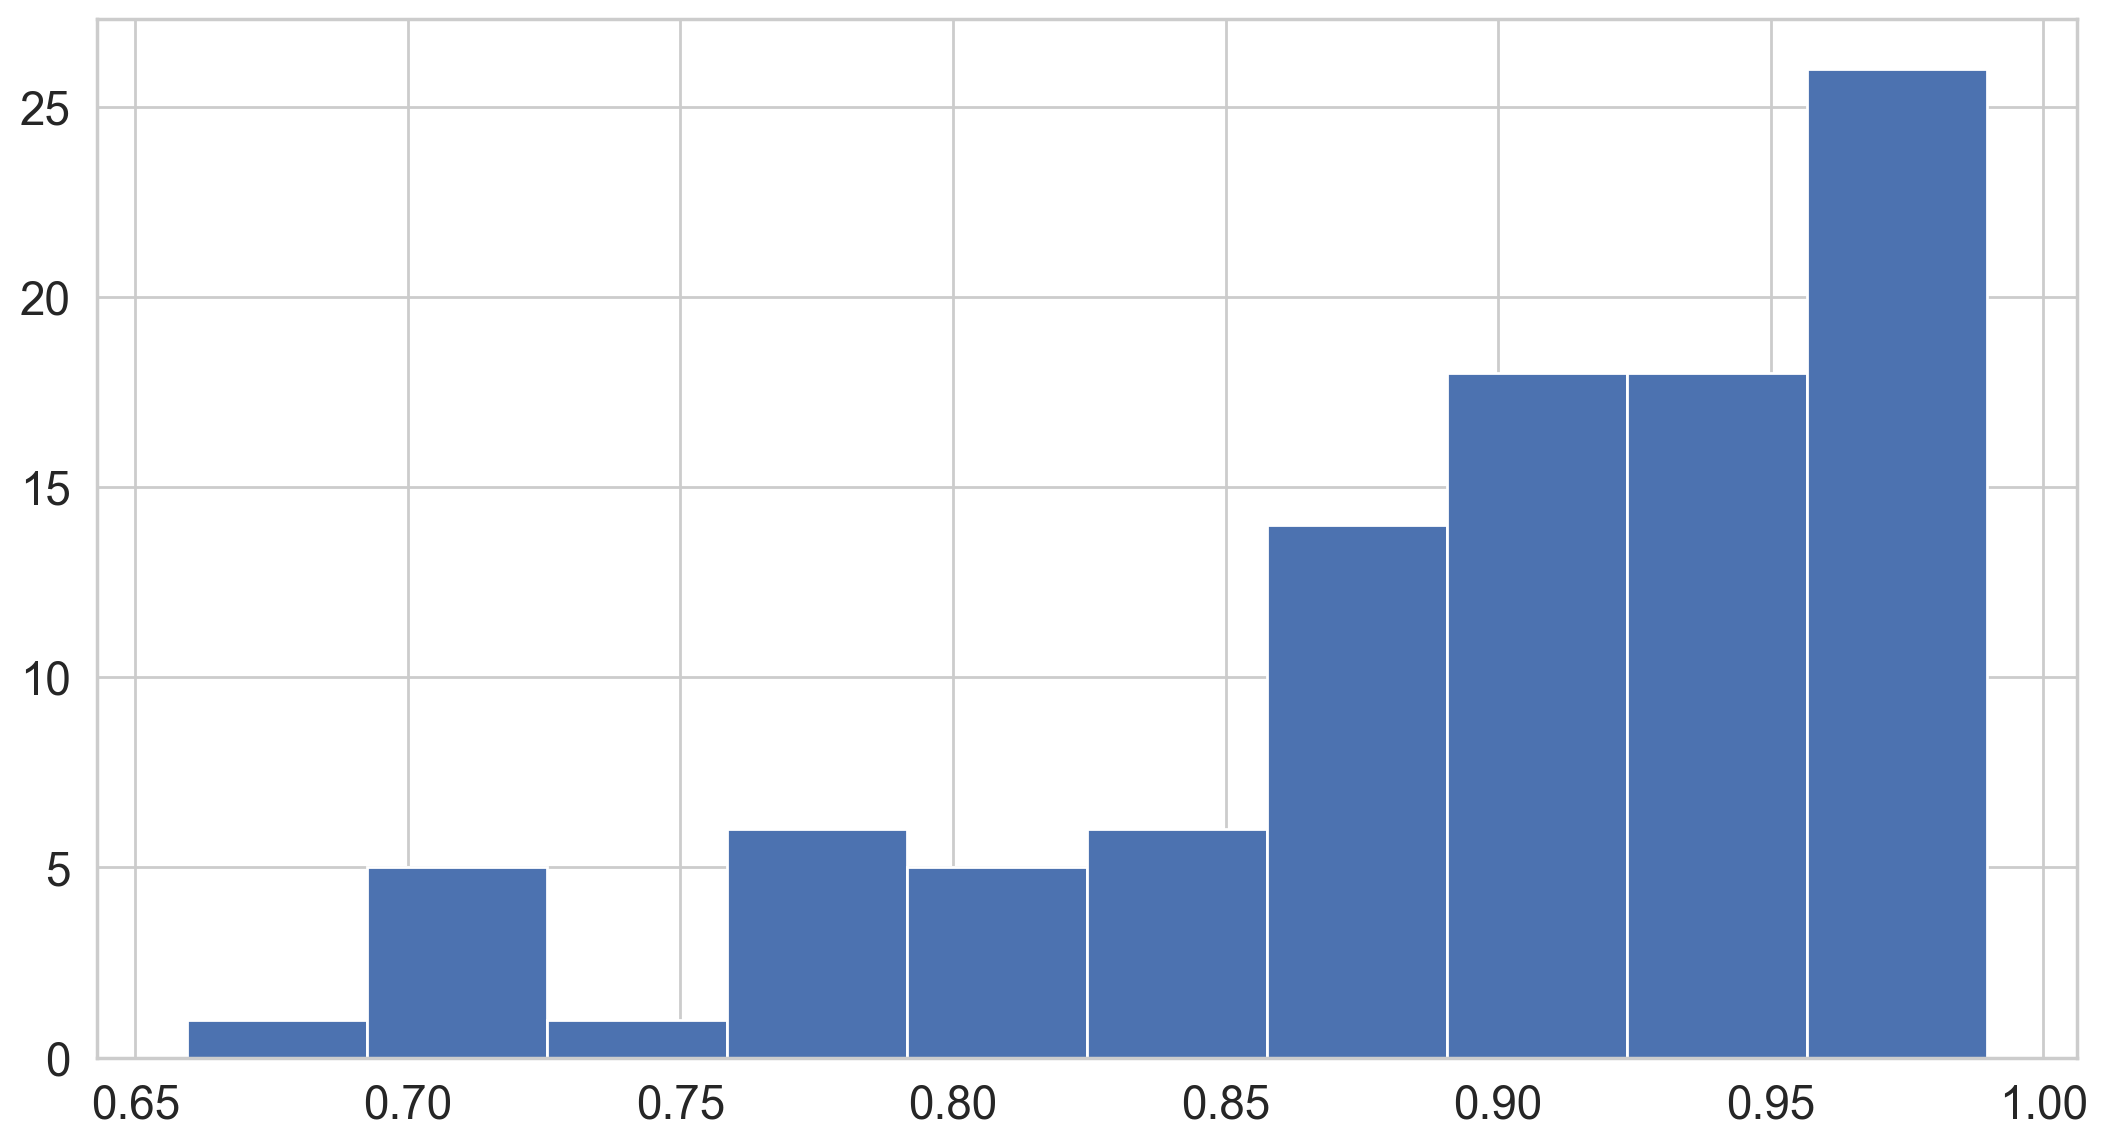

In [13]:
results_image = results.max(axis=(0, 1))
results_image.sort()

fig, ax = fovea.plt.subplots()
ax.hist(results_image)